In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix

from scipy.stats import (
    mannwhitneyu,
    fisher_exact
)

from sklearn.metrics import (
    auc,
    roc_curve,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
    roc_auc_score
)

from sklearn.model_selection import train_test_split


import json

from statannotations.Annotator import Annotator

# Data preprocessing

In [7]:
from functools import wraps
import datetime as dt

def log_step(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        tic = dt.datetime.now()
        result = func(*args, **kwargs)
        time_taken = str(dt.datetime.now() - tic)
        print(f"Step {func.__name__} - {func.__doc__}\nn_obs={result.shape[0]}, n_cols={result.shape[1]}\ntook {time_taken}s\n")
        return result
    return wrapper

In [33]:
@log_step
def start_pipeline(df):
    """creates a copy of DataFrame to avoid rewriting raw data"""
    return df.copy()

@log_step
def drop_utility_columns(df):
    """removes 'DO USUNIĘCIA' columns"""
    utility_columns = df.columns.str.contains("DO USUNIĘCIA")
    return df.loc[:, ~utility_columns]

@log_step
def rename_columns(df, mapping_file_path='./data/renaming.txt'):
    "renames columns using provided mapping file"
    with open(mapping_file_path, "r", encoding='utf-8') as f:
        renaming_dict = json.loads(f.read())
        return df.rename(columns=renaming_dict)

@log_step
def convert_float_cols(df):
    "cleans numerical columns & assigns right data type"
    num_cols = ['age', 'thyr_vol', 'affected_lob_vol', 'transverse', 'anteroposterior', 'longitudinal',
                'tsh', 'ft4', 'ft3', 'anti-tpo', 'anti-tg', 'trab', 'calcytonine']
    df[num_cols] = df[num_cols].replace(',', '.', regex=True).astype({k :float for k in num_cols})
    return df

@log_step
def convert_vals_in_col(df, col, replace_dict):
    "cleans numerical columns & assigns right data type"
    df[col] = df[col].replace(replace_dict)
    return df

In [34]:
df = pd.read_csv("./data/nodules.tsv", sep="\t", skiprows=2, na_values="-")

In [35]:
dataf = (df
 .pipe(start_pipeline)
 .pipe(drop_utility_columns)
 .pipe(rename_columns)
 .pipe(convert_float_cols)
 .pipe(convert_vals_in_col, col="thyr_diagnosis", replace_dict={"0": "thyroid goiter",
                                                                "1": "graves",
                                                                "2": "hashimoto",
                                                                "0,2": "hashimoto",
                                                                 np.nan: "healthy"})
)

Step start_pipeline - creates a copy of DataFrame to avoid rewriting raw data
n_obs=1079, n_cols=48
took 0:00:00.001739s

Step drop_utility_columns - removes 'DO USUNIĘCIA' columns
n_obs=1079, n_cols=45
took 0:00:00.002642s

Step rename_columns - renames columns using provided mapping file
n_obs=1079, n_cols=45
took 0:00:00.015463s

Step convert_float_cols - cleans numerical columns & assigns right data type
n_obs=1079, n_cols=45
took 0:00:00.024481s

Step convert_vals_in_col - cleans numerical columns & assigns right data type
n_obs=1079, n_cols=45
took 0:00:00.000937s



In [36]:
full = dataf[dataf['malignancy'].notnull()].copy()

# 1. Malignancy and thyroid nodule characteristics analysis 

In [37]:
# Creating subtable and droping one record without Bethesda score
roc_tab = full.loc[full['hp_diag'].notnull(), ['eu_tirads', 'bethesda', 'malignancy']].copy().dropna()
# Drop undiagnostic biopsies
roc_tab = roc_tab.drop(roc_tab[roc_tab['bethesda'] == 1].index)
roc_tab = roc_tab.assign(combined=roc_tab['bethesda']+roc_tab['eu_tirads'])

In [38]:
roc_tab["eu_tirads"].value_counts()

4.0    199
5.0    106
3.0     76
Name: eu_tirads, dtype: int64

## 1.1. Dimensions to malignancy of nodule 

Mann-Whitney U test for transverse measure: U=42327.0, p=3.65394407600866e-05
Mann-Whitney U test for anteroposterior measure: U=41346.0, p=0.00035361008917603247
Mann-Whitney U test for longitudinal measure: U=36889.0, p=5.4825778681658804e-11


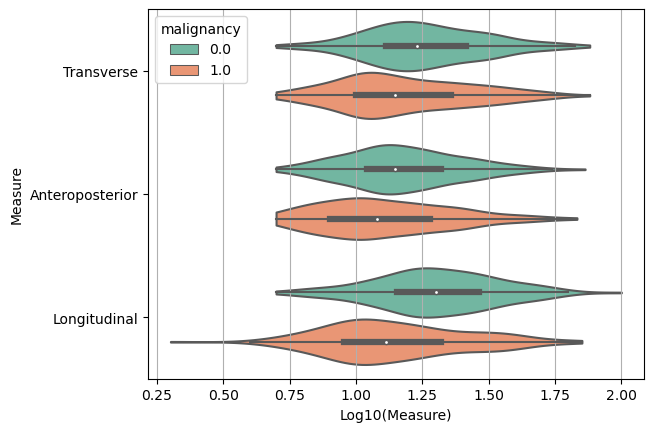

In [39]:
# melt all measures into single table
melted = full.melt(id_vars=["malignancy"], value_vars=["transverse", "anteroposterior", "longitudinal"], var_name="measure")
# take log of values
melted["log_value"] = np.log10(melted["value"] + 1)

# do a violinplot
g = sns.violinplot(x='log_value', y='measure', hue='malignancy', data=melted, palette="Set2", cut=0)
# correct labels
g.set_xlabel("Log10(Measure)")
g.set_ylabel("Measure")
g.set_yticklabels(['Transverse', 'Anteroposterior', 'Longitudinal'])

# add grid
g.grid(True, axis='x')

pairs = [
    ((0, "transverse"), (1, "transverse")),
    ((0, "anteroposterior"), (1, "anteroposterior")),
    ((0, "longitudinal"), (1, "longitudinal"))
    ]

# perform Mann-Whitney U test for each pair
for (malignant, measure), (benign, _) in pairs:
    u_stat, p_value = mannwhitneyu(
        melted.query("measure == @measure").loc[melted['malignancy'] == malignant, 'value'],
        melted.query("measure == @measure").loc[melted['malignancy'] == benign, 'value'],
        alternative="two-sided",
        nan_policy="omit"
    )
    print(f"Mann-Whitney U test for {measure} measure: U={u_stat}, p={p_value}")


### 1.1.1 Anteroposterior to transverse

/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/sklearn/lib/python3.10/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


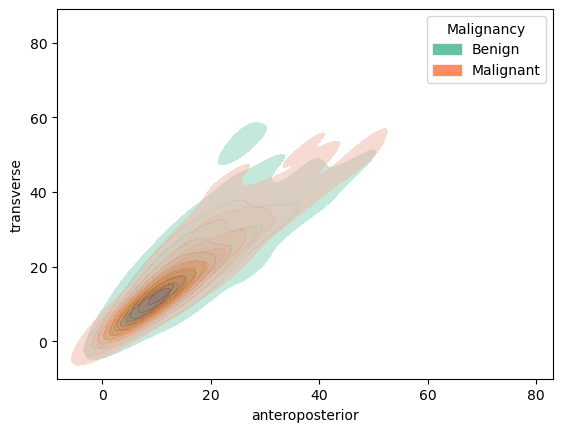

In [40]:
sns.color_palette("Set2")
g = sns.kdeplot(x="anteroposterior", y="transverse", hue="malignancy", data=full,
                fill=True, common_norm=True, alpha=.5, linewidth=0, palette="Set2")
# correct legend labels
g.legend_.set_title("Malignancy")
for t, l in zip(g.legend_.texts, ['Benign', 'Malignant']): t.set_text(l)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:2.835e-01 U_stat=3.317e+04


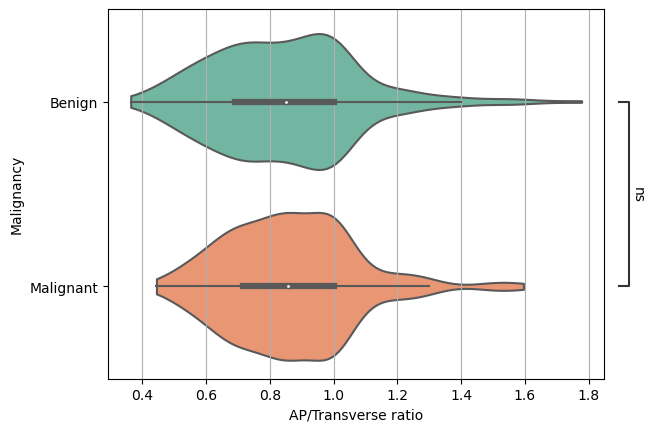

In [41]:
full["ap_to_t"] = full["anteroposterior"] / full["transverse"]
g = sns.violinplot(x="ap_to_t", y="malignancy", data=full, palette="Set2", cut=0,
                   orient="h")
# correct labels
g.set_xlabel("AP/Transverse ratio")
g.set_ylabel("Malignancy")
g.set_yticklabels(['Benign', 'Malignant'])
# pairs
pairs = [(0,1)]

# add grid
g.grid(True, axis='x')

annotator = Annotator(g, pairs, data=full, x="ap_to_t", y="malignancy", orient="h")
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate();


**Observations:**
- The distributions for anteroposterior-to-transverse dimension look similar
- Mann-Whitney test does not show statistically significant differences
- Contrary to literature, "wider-than-tall" rule does not seem to indicate malignancy in our data

### 1.1.2 Anteroposterior to longitudinal

/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/sklearn/lib/python3.10/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


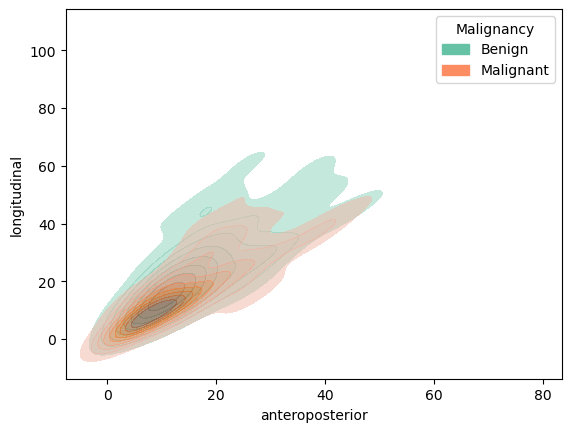

In [42]:
g = sns.kdeplot(x="anteroposterior", y="longitudinal", hue="malignancy", data=full, fill=True, common_norm=True, alpha=.5, linewidth=0, palette="Set2")
# correct legend labels
g.legend_.set_title("Malignancy")
for t, l in zip(g.legend_.texts, ["Benign", "Malignant"]): t.set_text(l)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:2.269e-09 U_stat=1.861e+04


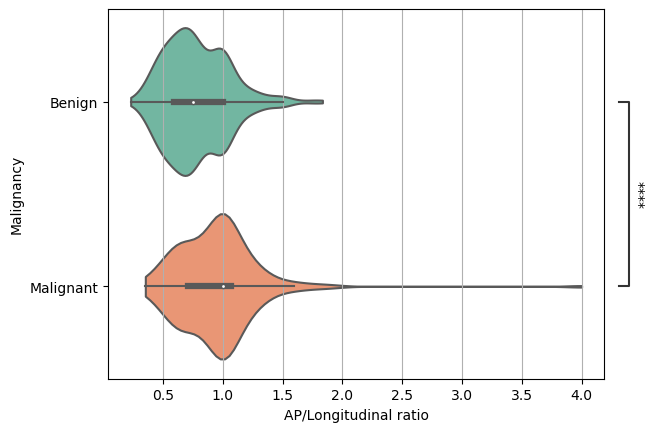

In [43]:
full["ap_to_l"] = full["anteroposterior"] / full["longitudinal"]
g = sns.violinplot(x="ap_to_l", y="malignancy", data=full, palette="Set2", cut=0, orient="h")
# correct labels
g.set_xlabel("AP/Longitudinal ratio")
g.set_ylabel("Malignancy")
g.set_yticklabels(['Benign', 'Malignant'])
# pairs
pairs = [(0,1)]

# add grid
g.grid(True, axis='x')

annotator = Annotator(g, pairs, data=full, x="ap_to_l", y="malignancy", orient="h")
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate();

**Observations:** 
- The distributions for anteroposterior-to-longitudinal are different
- Mann-Whitney test does show statisticall significant difference (p=2.26e-9)
- Contrary to literature, "wider-than-tall" rule does not seem to indicate malignancy in our data

# 1.1.3 ROC curve for dimensions only

In [44]:
size_roc_tab = full[["malignancy", "anteroposterior", "longitudinal", "transverse"]].dropna().reset_index(drop=True)
size_roc_tab = size_roc_tab.assign(
    ap_l=size_roc_tab["anteroposterior"] / size_roc_tab["longitudinal"],
    ap_t=size_roc_tab["anteroposterior"] / size_roc_tab["transverse"],
    l_ap=size_roc_tab["anteroposterior"] / size_roc_tab["longitudinal"],
    l_t=size_roc_tab["longitudinal"] / size_roc_tab["transverse"],
    ap_l_t = size_roc_tab["anteroposterior"] / (size_roc_tab["longitudinal"] * size_roc_tab["transverse"])
)
# for col in size_roc_tab:
#     size_roc_tab[col] = size_roc_tab[col] / size_roc_tab[col].max()
size_roc_tab.shape

(469, 9)

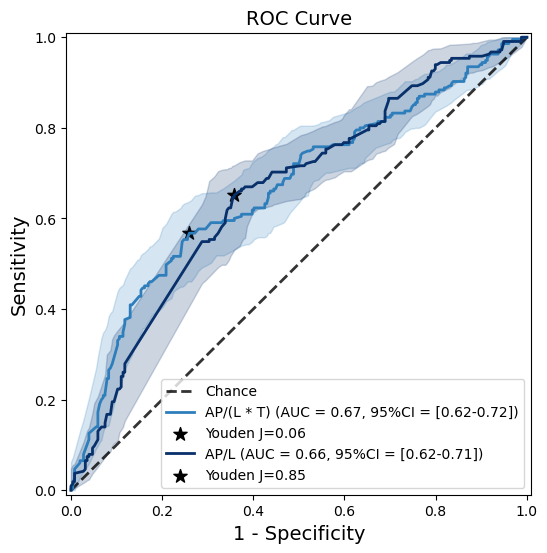

In [45]:
fig, ax = plt.subplots(figsize=(6, 6))

N_TRIALS = 100

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
        label='Chance', alpha=.8)

values_list = []

cols_of_interest = ['ap_l_t', 'ap_l']
labels = ["AP/(L * T)", "AP/L"]

for col, label in zip(cols_of_interest, labels):
    fpr, tpr, thresholds = roc_curve(size_roc_tab['malignancy'], size_roc_tab[col])
    auc_val = auc(fpr, tpr)

    values_list.append([col, auc_val, fpr, tpr, thresholds, label])

auc_df = pd.DataFrame(values_list, columns=["col", "auc", "fpr", "tpr", "thresholds", "label"])
colormap = cm.Blues(np.linspace(0.7, 1, len(cols_of_interest)))

for row, color in zip(auc_df.itertuples(), colormap):
        # add bootstrap
        tprs = []
        aucs = []
        for n in range(N_TRIALS):
                np.random.seed(n)
                indices = np.random.choice(size_roc_tab.index, size=size_roc_tab.shape[0], replace=True)
                fpr, tpr, thresholds = roc_curve(size_roc_tab.loc[indices, 'malignancy'], size_roc_tab.loc[indices, row.col])
                roc_auc_tmp = auc(fpr, tpr)
                # plot interpolated curve
                tpr = np.interp(row.fpr, fpr, tpr)
                tpr[0] = 0.0
                tprs.append(tpr)
                aucs.append(roc_auc_tmp)

        ax.plot(row.fpr, row.tpr, color=color,
        label=f'{row.label} (AUC = {row.auc:.2f}, 95%CI = [{np.percentile(aucs, 2.5):.2f}-{np.percentile(aucs, 97.5):.2f}])',
        lw=2, alpha=1)

        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis=0)
        lower_tprs = np.percentile(tprs, 2.5, axis=0)
        upper_tprs = np.percentile(tprs, 97.5, axis=0)

        ax.fill_between(row.fpr, lower_tprs, upper_tprs, color=color, alpha=0.2)

        # calculate youden J
        J = row.tpr - row.fpr
        ix = np.argmax(J)
        best_thresh = row.thresholds[ix]
        ax.scatter(row.fpr[ix], row.tpr[ix], marker='*', color='black', s=100, label=f"Youden J={best_thresh:.2f}")

ax.set_xlim(-0.01, 1.01)
ax.set_xlabel('1 - Specificity', fontsize=14)
ax.set_ylim(-0.01, 1.01)
ax.set_ylabel('Sensitivity', fontsize=14)

ax.legend(loc="lower right")
ax.set_title('ROC Curve', fontsize=14);
fig.savefig("figures/ROCs_dimensions.png", dpi=600, bbox_inches="tight")

In [46]:
print(f"Best test threshold for AP/(L * T) ratio: {best_thresh:.2f}")
print(f"Sensitivity: {row.tpr[ix]:.3f}")
print(f"Specificity: {1 - row.fpr[ix]:.3f}")

Best test threshold for AP/(L * T) ratio: 0.85
Sensitivity: 0.651
Specificity: 0.642


**Observations:**
- AP/L ratio is already a good predictor for malignancy, with an AUC of 0.66
- Optimal threshold is 0.85, with a **sensitivity of 0.65** and **specificity of 0.64**
- AP/(L * T) is also a good predictor
- The difference between ROC curves is not statistically significant, yet first one is easier to calculate

## 1.2 Bethesda scale ROC curve

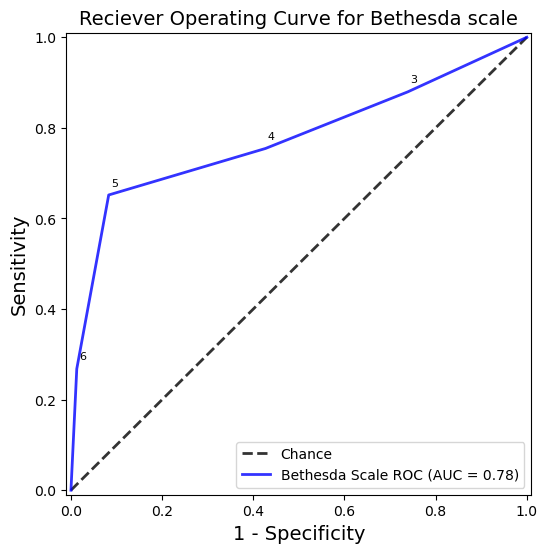

In [47]:
fpr, tpr, _ = roc_curve(roc_tab['malignancy'], roc_tab['bethesda'])
auc_bethesda = auc(fpr, tpr)
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
        label='Chance', alpha=.8)
ax.plot(fpr, tpr, color='b',
        label=r'Bethesda Scale ROC (AUC = %0.2f)' % auc_bethesda,
        lw=2, alpha=.8)

ax.set_xlim(-0.01, 1.01)
ax.set_xlabel('1 - Specificity', fontsize=14)
ax.set_ylim(-0.01, 1.01)
ax.set_ylabel('Sensitivity', fontsize=14)
# add thresholds over each point
for i in range(1, len(fpr)- 1):
    ax.text(fpr[i] + 0.005, tpr[i] + 0.02, f"{_[i]:.0f}", fontsize=8, color="black")


ax.legend(loc="lower right")
ax.set_title('Reciever Operating Curve for Bethesda scale', fontsize=14)
fig.savefig("figures/ROC_bethesda.png", dpi=600, bbox_inches="tight");

In [48]:
# display a confusion matrix for Bethesda

bethesda_tab = pd.crosstab(roc_tab['malignancy'], roc_tab['bethesda'], normalize="columns")
# display in percentages
bethesda_tab = bethesda_tab.apply(lambda x: x*100, axis=1)
# change row names to Benign and Malignant
bethesda_tab.columns.name = "Bethesda scale"
bethesda_tab.index = ["Benign", "Malignant"]
bethesda_tab.index.name = "Malignancy"

display(bethesda_tab)

Bethesda scale,2.0,3.0,4.0,5.0,6.0
Malignancy,,,,,
Benign,60.294118,63.636364,70.12987,11.340206,3.225806
Malignant,39.705882,36.363636,29.87013,88.659794,96.774194


# 1.4 Statistics for EU-TIRADS

In [49]:
# display a confusion matrix for EU-TIRADS

eu_tirads_tab = pd.crosstab(roc_tab['malignancy'], roc_tab['eu_tirads'], normalize="columns")
# display in percentages
eu_tirads_tab = eu_tirads_tab.apply(lambda x: x*100, axis=1)
# change row names to Benign and Malignant
eu_tirads_tab.columns.name = "EU-TIRADS"
eu_tirads_tab.index = ["Benign", "Malignant"]
eu_tirads_tab.index.name = "Malignancy"

display(eu_tirads_tab)

EU-TIRADS,3.0,4.0,5.0
Malignancy,,,
Benign,61.842105,44.723618,19.811321
Malignant,38.157895,55.276382,80.188679


## 1.5 Other demographic variables and lab tests

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:1.052e-07 U_stat=4.933e+04


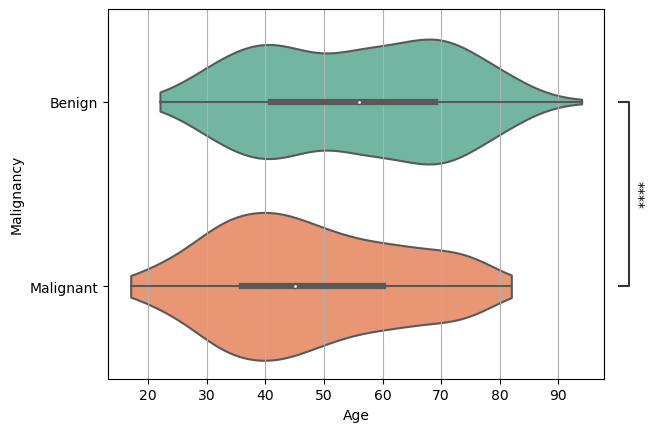

In [50]:
g = sns.violinplot(x='age', y='malignancy', data=full, palette="Set2", cut=0, orient="h")
# correct labels
g.set_xlabel("Age")
g.set_ylabel("Malignancy")
g.set_yticklabels(['Benign', 'Malignant'])
# pairs
pairs = [(0,1)]

# add grid
g.grid(True, axis='x')

annotator = Annotator(g, pairs, data=full, x="age", y="malignancy", orient="h")
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate();

**Observations:**
- the age differnce in groups can be explained by multiple nodules appearing with age
- the presence of nodule in young age makes it more likely to be malignant 

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:5.373e-03 U_stat=2.998e+04


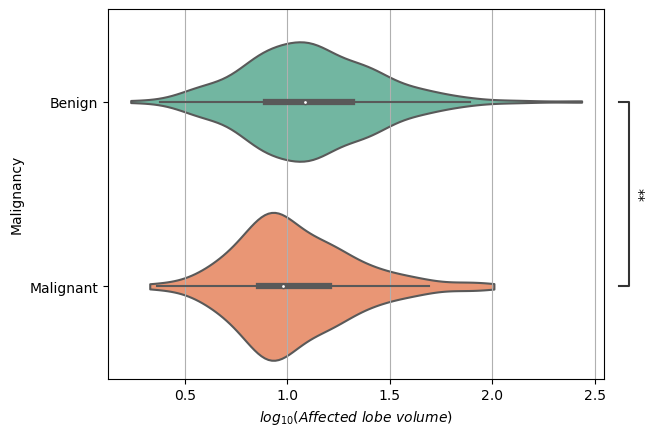

In [51]:
# log10 of affected lob volume
full["log_affected_lob_vol"] = np.log10(full["affected_lob_vol"] + 1)

# violinplot
g = sns.violinplot(x='log_affected_lob_vol', y='malignancy', data=full, palette="Set2", cut=0, orient="h")
# correct labels
g.set_xlabel("$log_{10}(Affected\ lobe\ volume)$")
g.set_ylabel("Malignancy")
g.set_yticklabels(['Benign', 'Malignant'])
# pairs
pairs = [(0,1)]

# add grid
g.grid(True, axis='x')

annotator = Annotator(g, pairs, data=full, x="log_affected_lob_vol", y="malignancy", orient="h")
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate();

**Observations:**
- larger volume of thyroid gland is inversely correlated with malignancy
- this can be explained by formation of a lot of benign lesions in enlarged thyroid gland

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:9.830e-02 U_stat=2.961e+04


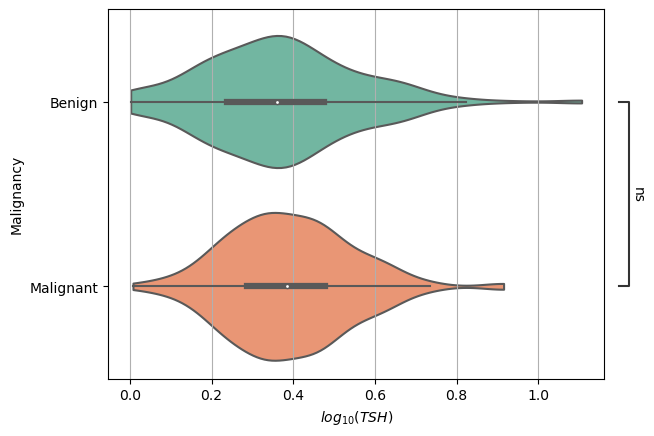

In [52]:
# log10 TSH
full["log_tsh"] = np.log10(full["tsh"] + 1)
# plot TSH
g = sns.violinplot(x='log_tsh', y='malignancy', data=full, palette="Set2", cut=0, orient="h")
# correct labels
g.set_xlabel("$log_{10}(TSH)$")
g.set_ylabel("Malignancy")
g.set_yticklabels(['Benign', 'Malignant'])
# pairs
pairs = [(0,1)]

# add grid
g.grid(True, axis='x')

annotator = Annotator(g, pairs, data=full, x="tsh", y="malignancy", orient="h")
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate();

In [53]:
# crosstab for sex
sex_tab = pd.crosstab(full['malignancy'], full['sex'], normalize="columns")
# correct labels
sex_tab.columns = ["F", "M"]
sex_tab.columns.name = "Sex"
sex_tab.index = ["Benign", "Malignant"]
sex_tab.index.name = "Malignancy"

display(sex_tab)

# do a Fisher exact on unnormalized table
fisher_tab = pd.crosstab(full['malignancy'], full['sex'])
_, p = fisher_exact(fisher_tab)

print(f"P-value for Fisher exact test: {p:.3f}")

Sex,F,M
Malignancy,,
Benign,0.549474,0.453488
Malignant,0.450526,0.546512


P-value for Fisher exact test: 0.126


**Observations:**
- although difference is not statistically significant, sex seems to be an important predictor for malignancy

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:3.235e-03 U_stat=3.345e+04


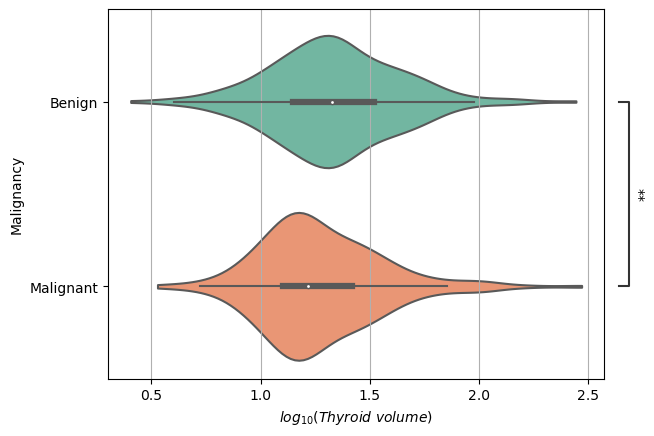

In [54]:
# log thyr vol
full["log_thyr_vol"] = np.log10(full["thyr_vol"] + 1)
# plot thyr vol
g = sns.violinplot(x='log_thyr_vol', y='malignancy', data=full, palette="Set2", cut=0, orient="h")

# correct labels
g.set_xlabel("$log_{10}(Thyroid\ volume)$")
g.set_ylabel("Malignancy")
g.set_yticklabels(['Benign', 'Malignant'])
# pairs
pairs = [(0,1)]

# add grid
g.grid(True, axis='x')

annotator = Annotator(g, pairs, data=full, x="log_thyr_vol", y="malignancy", orient="h")
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate();

**Observations:**
- thyroid volume is an important predictor for malignancy

In [123]:
full["ap_l"] = full["anteroposterior"] / full["longitudinal"]
predictors = ["age",
              "sex",
#              "loc",
              # "nodule_count",
              "transverse",
            #   "ap_l",
              "anteroposterior",
              "longitudinal",
              "calc",
              "microcalc",
              "thyr_vol",
              "tsh",
#              "thyr_diagnosis",
#              "halo",
#              "echogen",
#              "vasc_type",
#               "torbiele",
#               "C(bethesda)"
#              "C(eu_tirads)"
             ]
formula_preds = [f"C({col})" if full[col].dtype == "O" else col for col in predictors]

In [144]:
# run chi squared test
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(pd.crosstab(full['malignancy'], full['microcalc']))
print(f"Chi-squared test for microcalcification: chi2={chi2}, p={p}")

Chi-squared test for microcalcification: chi2=13.306311151640521, p=0.00026451425447846123


In [124]:
# full["nodule_count"] = full["nodule_count"].str.strip()
# full["torbiele"] = full["torbiele"].str.strip()
# full["nodule_count"] = [x if x in ["1"] else "mnogie" for x in full["nodule_count"]]

In [125]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# full["nodule_count"] = le.fit_transform(full["nodule_count"])
# full["sex"] = le.fit_transform(full["sex"])
# full["calc"] = le.fit_transform(full["calc"])
# full["microcalc"] = le.fit_transform(full["microcalc"])

# # explicitly require this experimental feature
# from sklearn.experimental import enable_iterative_imputer  # noqa
# # now you can import normally from sklearn.impute
# from sklearn.impute import IterativeImputer

# mice_imputer = IterativeImputer(random_state=42, sample_posterior=True, max_iter=100)
# full[predictors] = mice_imputer.fit_transform(full[predictors])

In [126]:
formula = "malignancy ~ " + "+".join(formula_preds)
dm = dmatrix("+".join(formula.split("~")), full, return_type="dataframe")# describe age, stratify into malignancy

In [163]:
variable = "tsh"
tab = full.groupby("malignancy")[variable].describe()
display(tab)
# run statistical test
t_stat, p_value = mannwhitneyu(full.query("malignancy == 0")[variable], full.query("malignancy == 1")[variable], alternative="two-sided", nan_policy="omit")
print(f"Mann-Whitney U test for age: U={t_stat}, p={p_value}")

,count,mean,std,min,25%,50%,75%,max
malignancy,,,,,,,,
0.0,273.0,1.597538,1.423835,0.005,0.727,1.29,1.98,11.76
1.0,237.0,1.626034,1.059542,0.018,0.935,1.43,2.01,7.22


Mann-Whitney U test for age: U=29606.0, p=0.09829871991816501


In [155]:
# sex contingency table and test
from scipy.stats import chi2_contingency
display(pd.crosstab(full['malignancy'], full["microcalc"], normalize="index"))
tab = pd.crosstab(full['malignancy'], full["microcalc"])
chi2, p, dof, expected = chi2_contingency(tab)
display(tab)
print(f"Chi-squared test: {chi2}, p={p}")

microcalc,nie,tak
malignancy,,
0.0,0.927586,0.072414
1.0,0.820408,0.179592


microcalc,nie,tak
malignancy,,
0.0,269,21
1.0,201,44


Chi-squared test: 13.306311151640521, p=0.00026451425447846123


In [127]:
formula

'malignancy ~ age+C(sex)+transverse+anteroposterior+longitudinal+C(calc)+C(microcalc)+thyr_vol+tsh'

In [128]:
X, y = dm.drop(columns="malignancy"), dm.malignancy
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [129]:
model = sm.Logit(y_train, X_train).fit(method='ncg', maxiter=8000)

Optimization terminated successfully.
         Current function value: 0.599863
         Iterations: 13
         Function evaluations: 23
         Gradient evaluations: 23
         Hessian evaluations: 13


In [130]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             malignancy   No. Observations:                  280
Model:                          Logit   Df Residuals:                      270
Method:                           MLE   Df Model:                            9
Date:                Wed, 28 Feb 2024   Pseudo R-squ.:                  0.1273
Time:                        16:39:12   Log-Likelihood:                -167.96
converged:                       True   LL-Null:                       -192.47
Covariance Type:            nonrobust   LLR p-value:                 1.647e-07
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.4831      0.611      4.064      0.000       1.286       3.681
C(sex)[T.M]             0.5028      0.393      1.279      0.201      -0.268       1.273
C(calc)[T.tak]          0.2490      0.424      0.588      0.557      -0.582       1.080
C(microcalc)[T.tak]     0.8732      0.465      1.879      0.060      -0.038       1.784
age                    -0.0376      0.009     -4.233      0.000      -0.055      -0.020
transverse             -0.0469      0.027     -1.707      0.088      -0.101       0.007
anteroposterior         0.0960      0.037      2.594      0.009       0.023       0.168
longitudinal           -0.0696      0.020     -3.475      0.001      -0.109      -0.030
thyr_vol                0.0061      0.007      0.891      0.373      -0.007       0.020
tsh                    -0.2048      0.132     -1.546      0.122      -0.464       0.055
=======================================================================================
"""

In [131]:
train_scores = model.predict(X_train)
roc_auc_score(y_test, model.predict(X_test))

0.7231800766283526

In [132]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))


# test_scores = model.predict(X_test)
# for n, score in enumerate([train_scores]):
#     roc_display = RocCurveDisplay.from_predictions(y_train, score,
#                                                    ax=ax1, name = f"Train cohort")
#     roc_display.ax_.set(xlabel="False Positive Rate", ylabel="True Positive Rate")

#     pr_display = PrecisionRecallDisplay.from_predictions(y_train, score,
#                                                          ax=ax2, name=f"Train cohort")
#     pr_display.ax_.set(xlabel="Recall", ylabel="Precision", ylim=(0,1))

# for n, score in enumerate([test_scores]):
#     roc_display = RocCurveDisplay.from_predictions(y_test, score,
#                                                    ax=ax1, name = f"Test cohort")
#     roc_display.ax_.set(xlabel="1 - Specificity", ylabel="Sensitivity")

#     pr_display = PrecisionRecallDisplay.from_predictions(y_test, score,
#                                                          ax=ax2, name=f"Test cohort")
#     pr_display.ax_.set(xlabel="Recall", ylabel="Precision", ylim=(0,1))

# train_scores = [model.predict(X_train)]

# ax1.plot([0, 1], [0, 1], color='k', alpha=0.5, linestyle='--', label="Chance")
# ax1.legend()
# ax1.set_title("Receiver Operator Characteristics")

# chance = y_test.sum() / len(y_test)
# ax2.plot([0, 1], [chance, chance], linestyle="--", label="Chance", color="k", alpha=0.5)
# ax2.legend(loc="lower right")
# ax2.set_title("Precision-Recall Curve")
# fig.savefig("figures/ROC_LR.png", dpi=600, bbox_inches="tight");

In [133]:
# import RFC
from sklearn.ensemble import RandomForestClassifier
# import randomized search
from sklearn.model_selection import RandomizedSearchCV

# fine tune random forest classifier
rf = RandomForestClassifier(random_state=42)

# search grid
param_grid = {
    "n_estimators": [10, 15, 20, 25, 30, 35, 40, 45, 50],
    "max_depth": [5, 10, 15, 20, 25, 30],
    "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "min_samples_leaf": [1, 2, 3, 4],
    "max_features": ["sqrt", "log2"],
    "criterion": ["gini", "entropy"],
    "bootstrap": [True, False],
}

# random search
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=500, cv=5, verbose=1, random_state=42, n_jobs=48, scoring="roc_auc")

rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=500, n_jobs=48,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [10, 15, 20, 25, 30, 35,
                                                         40, 45, 50]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [134]:
# random search cv with logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42, max_iter=10000)

# search grid
param_grid = {
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "dual": [True, False],
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "fit_intercept" : [True],
    "intercept_scaling" : [1, 10, 100, 1000],
    "class_weight" : [None, "balanced"],
    "solver" : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}

# random search
lr_random = RandomizedSearchCV(estimator=lr, param_distributions=param_grid, n_iter=3000, cv=5, verbose=1, random_state=42, n_jobs=16, scoring="roc_auc")

lr_random.fit(X_train, y_train)

Fitting 5 folds for each of 2240 candidates, totalling 11200 fits


/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/sklearn/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 2240 is smaller than n_iter=3000. Running 2240 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/sklearn/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/sklearn/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/sklearn/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=10000,
                                                random_state=42),
                   n_iter=3000, n_jobs=16,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                              1000],
                                        'class_weight': [None, 'balanced'],
                                        'dual': [True, False],
                                        'fit_intercept': [True],
                                        'intercept_scaling': [1, 10, 100, 1000],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=42, scoring='roc_auc', verbose=1)

In [135]:
from collections import defaultdict

# LR
best_lr = lr_random.best_estimator_
best_lr.fit(X_train, y_train)
preds = pd.Series(best_lr.predict_proba(X_test)[:, 1], index=X_test.index)

# RF
tuned_rf = rf_random.best_estimator_
tuned_rf.fit(X_train, y_train)
tuned_rf_preds = pd.Series(tuned_rf.predict_proba(X_test)[:, 1], index=X_test.index)

# Reg
preds = model.predict(X_test)

bootstrap_scores = defaultdict(list)

# bootstrap scores for all three models
n_bootstraps = 100
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = np.random.randint(low=0, high=len(preds), size=len(preds))
    if len(np.unique(y_test.iloc[indices])) < 2:
        continue

    # LR
    bootstrap_score = roc_auc_score(y_test.iloc[indices], preds.iloc[indices])
    bootstrap_scores["LR"].append(bootstrap_score)

    # RF
    bootstrap_score = roc_auc_score(y_test.iloc[indices], tuned_rf_preds.iloc[indices])
    bootstrap_scores["RF"].append(bootstrap_score)

    # Reg
    bootstrap_score = roc_auc_score(y_test.iloc[indices], preds.iloc[indices])
    bootstrap_scores["Reg"].append(bootstrap_score)

    # # Calibrated
    # bootstrap_score = roc_auc_score(y_test.iloc[indices], calibrated_lr_preds.iloc[indices])
    # bootstrap_scores["Calibrated"].append(bootstrap_score)


# seclect only values in 95% CI from bootstrap scores
for key in bootstrap_scores.keys():
    bootstrapped_scores = np.array(bootstrap_scores[key])
    lower, upper = np.percentile(bootstrapped_scores, [2.5, 97.5])
    bootstrap_scores[key] = bootstrapped_scores[(bootstrapped_scores > lower) & (bootstrapped_scores < upper)]

# make a df out of results
bootstrap_scores = pd.DataFrame(bootstrap_scores)

/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/sklearn/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/sklearn/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/sklearn/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RF vs. LR: t-test independent samples, P_val:4.393e-03 t=2.884e+00


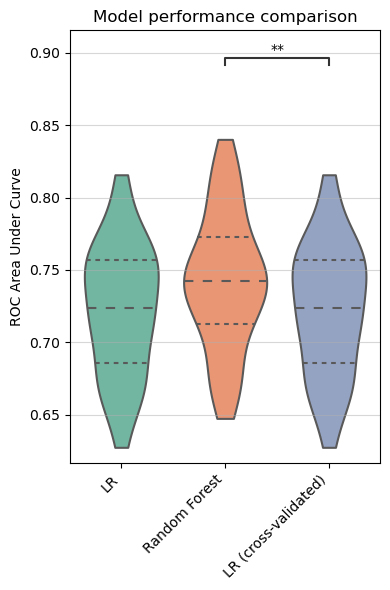

In [136]:
# violin_df["Model"] = violin_df["Model"].replace({"LR": "Logistic Regression - ML", "RF": "Random Forest", "Reg": "Logistic Regression",
#                                                  "Calibrated" : "Calibrated Logistic Regression"})

order=["Reg", "RF", "LR"]

# plot violin plot
fig, ax = plt.subplots(figsize=(4, 6))
sns.violinplot(data=bootstrap_scores, ax=ax, inner="quartile", palette="Set2", saturation=0.75,
               order=order, cut=0)

# rotate x axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# change y axis label
ax.set_ylabel("ROC Area Under Curve")
ax.set_title("Model performance comparison")
# adjust figure to look nice


pairs = [("LR", "RF")]

annotator = Annotator(ax, pairs, data=bootstrap_scores, order=order, plot="violinplot")
annotator.configure(test='t-test_ind', text_format='star', loc='inside')
annotator.apply_and_annotate()

# add grid
ax.grid(axis="y", alpha=0.5)

# rename x labels
ax.set_xticklabels(["LR", "Random Forest", "LR (cross-validated)"])

fig.tight_layout()


fig.savefig("figures/model_comparison.png", dpi=1200, bbox_inches="tight");

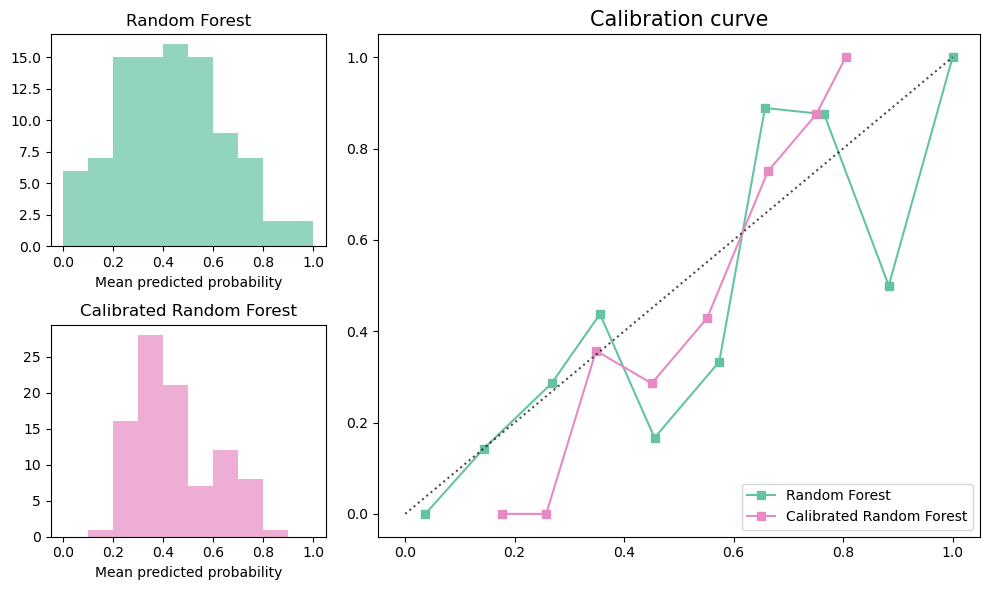

In [137]:
# make a calibration plots for 3 models
# calibrate Random Forest
from sklearn.calibration import CalibratedClassifierCV


calibrated_rf = CalibratedClassifierCV(tuned_rf, cv=5, method="sigmoid")
calibrated_rf.fit(X_train, y_train)


# import BinaryResultsWrapper
from statsmodels.discrete.discrete_model import BinaryResultsWrapper
from sklearn.calibration import calibration_curve

# create 3 panel figure with one large square on the left and two half-sized squares on the right, one under another
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1:])
ax3.set_title("Calibration curve", fontsize=15)

lr_ml_color, lr_color = sns.color_palette("Set2")[3], sns.color_palette("Set2")[0]
# for each model do a prediction and make a calibration curve
for m, name, color, ax in zip([rf_random, calibrated_rf], ["Random Forest", "Calibrated Random Forest"],
                              [lr_color, lr_ml_color], [ax1, ax2]):
    # make a prediction
    if type(m) == BinaryResultsWrapper:
        preds = m.predict(X_test)
    else:
        preds = m.predict_proba(X_test)[:, 1]

    # get calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, preds, n_bins=10)
    # plot a histogram of mean predicted value on the ax
    ax.hist(preds, range=(0, 1), bins=10, label=name, color=color, alpha=0.7)
    # add title to a histogram
    ax.set_title(name, fontsize=12)
    # add x axis label
    ax.set_xlabel("Mean predicted probability")

    # plot calibration curve, use 2nd and 3rd color from Set2
    ax3.plot(mean_predicted_value, fraction_of_positives, "s-", label=name, color=color)

# add legend
plt.legend(loc="lower right")
# add ideal calibration
plt.plot([0, 1], [0, 1], "k:", label="Ideal calibration", alpha=0.7)

# make plot look nice
plt.tight_layout()
# save figure
fig.savefig("figures/calibration_curves.png", dpi=1200, bbox_inches="tight");

Spearman correlation coefficient for EU-TIRADS: 0.277, p-value: 0.008153
Spearman correlation coefficient for calibrated Random Forest: 0.476, p-value: 0.000001


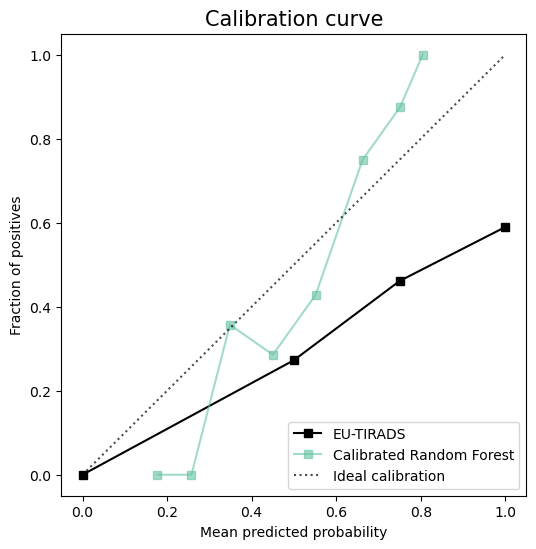

In [141]:
from scipy.stats import spearmanr

# normalize EU-TIRADS for the range of 0-1
full["eu_tirads_norm"] = (full["eu_tirads"] - 1) / (full["eu_tirads"].max() - 1)

# plot calibration curve for EU-TIRADS
fig, ax = plt.subplots(figsize=(6, 6))
fraction_of_positives, mean_predicted_value = calibration_curve(full["malignancy"], full["eu_tirads_norm"], n_bins=10)
# replace last predicted value with 1
mean_predicted_value[-1] = 1
# insert values at 0
mean_predicted_value = np.insert(mean_predicted_value, 0, 0)
fraction_of_positives = np.insert(fraction_of_positives, 0, 0)
ax.plot(mean_predicted_value, fraction_of_positives, "s-", label="EU-TIRADS", color="black")
# calibration curve for calibrated RF
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, calibrated_rf.predict_proba(X_test)[:, 1], n_bins=10)
# select first color from Set2
color = sns.color_palette("Set2")[0]
ax.plot(mean_predicted_value, fraction_of_positives, "s-", label="Calibrated Random Forest", color=color, alpha=0.6)

ax.plot([0, 1], [0, 1], "k:", label="Ideal calibration", alpha=0.7)

ax.set_title("Calibration curve", fontsize=15)
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Fraction of positives")
ax.legend(loc="lower right")

coef, p = spearmanr(full.loc[X_test.index]["eu_tirads_norm"], y_test, nan_policy="omit")
print(f"Spearman correlation coefficient for EU-TIRADS: {coef:.3f}, p-value: {p:.6f}")
coef, p = spearmanr(calibrated_rf.predict_proba(X_test)[:, 1], y_test, nan_policy="omit")
print(f"Spearman correlation coefficient for calibrated Random Forest: {coef:.3f}, p-value: {p:.6f}")

fig.savefig("figures/calibration_curves_eu_tirads.png", dpi=1200, bbox_inches="tight");

In [106]:
model = sm.Logit(y_train, X_train).fit(method='ncg', maxiter=8000)

Optimization terminated successfully.
         Current function value: 0.606552
         Iterations: 11
         Function evaluations: 20
         Gradient evaluations: 20
         Hessian evaluations: 11


In [107]:
res_df = pd.concat([model.conf_int(), model.params, model.pvalues], axis=1).iloc[1:, :]
res_df.columns = ["LCI", "UCI", "Center", "p"]
res_df = res_df.sort_values("Center")

/tmp/ipykernel_139478/4088950637.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticklabels)
/tmp/ipykernel_139478/4088950637.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([np.round(np.exp(x), 1) for x in ax.get_xticks()]);


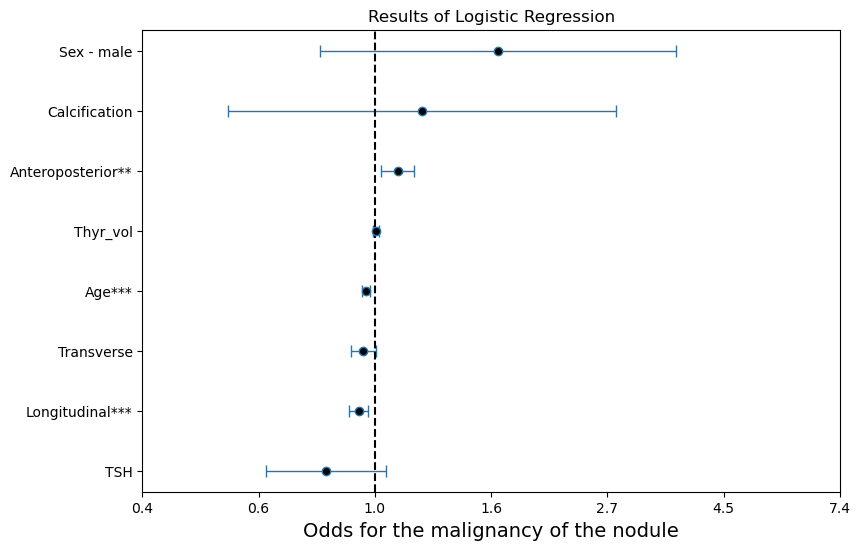

In [108]:
fig,ax = plt.subplots(figsize=(9, 6))
lower_error, upper_error = np.absolute(res_df.Center - res_df.LCI), np.absolute(res_df.UCI - res_df.Center)
ax.errorbar(res_df.Center, range(len(res_df)), xerr=[lower_error, upper_error],  elinewidth=1, capsize=4,
            markerfacecolor='k', fmt='o')
ax.set_yticks(np.arange(len(res_df)))
y_labels = [x.capitalize() for x  in res_df.index]

replace_dict = {
    "C(nodule_count)[t.mnogie]" : "Multiple nodules (>1)",
    "Tsh" : "TSH",
    "C(calc)[t.tak]" : "Calcification",
    "C(microcalc)[t.tak]" : "Microcalcification",
    "C(sex)[t.m]" : "Sex - male"
}

# use replace dict for y_labels
y_labels = [replace_dict.get(x, x) for x in y_labels]

# use asterixes to mark significant traits in y_labels from res_df.p with different cut-offs
y_labels = [f"{x}{'*' * int(p < 0.05) + '*' * int(p < 0.01) + '*' * int(p < 0.001)}" for x, p in zip(y_labels, res_df.p)]

ax.set_yticklabels(labels=y_labels)
ax.axvline(0, color='k', linestyle="--")
ax.set_xlabel('Odds for the malignancy of the nodule', size=14)
ax.set_xlim(-1, 2)


ticklabels = ["Benign", *list(np.arange(-0.5, 2, 0.5)), "Malignant"]
ax.set_xticklabels(ticklabels)

ax.set_title("Results of Logistic Regression")
fig.savefig("figures/LR_results.png", dpi=600, bbox_inches="tight")
# convert log odds ratios in x-axis to odds ratios
ax.set_xticklabels([np.round(np.exp(x), 1) for x in ax.get_xticks()]);


In [109]:
res_df

,LCI,UCI,Center,p
tsh,-0.466639,0.048016,-0.209312,0.110882
longitudinal,-0.109054,-0.031032,-0.070043,0.000433
transverse,-0.104088,0.002957,-0.050565,0.064070
age,-0.056258,-0.021816,-0.039037,0.000009
thyr_vol,-0.007964,0.019312,0.005674,0.414844
anteroposterior,0.025752,0.169949,0.097850,0.007814
C(calc)[T.tak],-0.630340,1.037231,0.203445,0.632483
C(sex)[T.M],-0.236203,1.295576,0.529687,0.175257


In [110]:
%load_ext watermark

In [111]:
watermark -v -m -p numpy,pandas,matplotlib,seaborn,statsmodels,scipy,sklearn,json

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.7.0

numpy      : 1.23.5
pandas     : 1.5.2
matplotlib : 3.6.2
seaborn    : 0.11.2
statsmodels: 0.13.2
scipy      : 1.9.3
sklearn    : 1.1.3
json       : 2.0.9

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 3.10.0-1160.90.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 144
Architecture: 64bit

